## Last Value Estimator that is Scikit-Learn compatible

In [8]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.model_selection import TimeSeriesDailyRollingSplit

# Load the sunspots dataset
sunspots = sm.datasets.sunspots.load_pandas().data

# Create a new feature by shifting the sunspots count
sunspots['lagged_sunspots'] = sunspots['SUNACTIVITY'].shift(1)

# Drop the first row which will have a NaN value in the 'lagged_sunspots' column
sunspots = sunspots.iloc[1:]

# Reset the index and rename the column
sunspots_reset = sunspots.reset_index().rename(columns={'index': 'date'})

In [2]:
sunspots_reset.head()

,date,YEAR,SUNACTIVITY,lagged_sunspots
0,1,1701.0,11.0,5.0
1,2,1702.0,16.0,11.0
2,3,1703.0,23.0,16.0
3,4,1704.0,36.0,23.0
4,5,1705.0,58.0,36.0


In [15]:
from sklearn.base import BaseEstimator

class LastValueEstimator(BaseEstimator):
    """Last-value prediction for time series.
    
    This estimator always predicts the lastest value of y that it has seen.
    """
    def __init__(self, reference_column):
        self.reference_column = reference_column

    def fit(self, X, y=None):
        if self.reference_column not in X.columns:
            raise ValueError("The dataframe does not include the reference column.")
        sorted_indices = X[self.reference_column].argsort()
        X_sorted = X.iloc[sorted_indices]
        y_sorted = y.iloc[sorted_indices]
        
        # Store the mean of y_sorted values corresponding to the last date
        self.last_value_ = y_sorted[X_sorted[self.reference_column] ==\
                                     X_sorted[self.reference_column].iloc[-1]].mean()
        return self

    def predict(self, X):
        # Return an array with the same length as X, filled with the last value
        return [self.last_value_] * len(X)

## A Simple Backtest

In [16]:
X = sunspots_reset[['YEAR', 'date', 'lagged_sunspots']]
y = sunspots_reset['SUNACTIVITY']
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)

In [17]:
from sklearn.model_selection import cross_val_score

neg_abs_error_last_value = cross_val_score(
    LastValueEstimator(reference_column="date"),
    X,
    y,
    cv=ts_split,
    scoring="neg_mean_absolute_error",
)

In [22]:
plt.plot(neg_abs_error_last_value)

In [7]:
import numpy as np
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100)
estimator = LastValueEstimator('date')
predictions = np.full(y.shape, np.nan)

# Loop over the splits
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the estimator and make predictions
    estimator.fit(X_train, y_train)
    predictions[test_index] = estimator.predict(X_test)

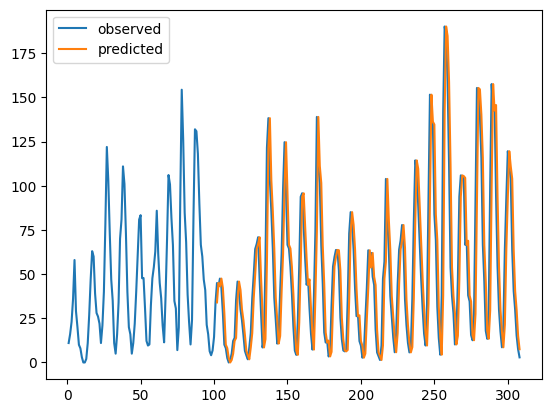

In [8]:
plt.plot(sunspots_reset['date'], sunspots_reset['SUNACTIVITY'], label='observed')
plt.plot(sunspots_reset['date'], predictions, label='predicted')
plt.legend()

## XGBoost Model

In [26]:
import xgboost
import sklearn
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.model_selection import OptunaCVOptimizer
from quantbullet.model.consts import TypicalHyperparameterRanges
from quantbullet.model_selection import TimeSeriesDailyRollingSplit

# Load the sunspots dataset
sunspots = sm.datasets.sunspots.load_pandas().data

# Create a new feature by shifting the sunspots count
sunspots['lagged_sunspots'] = sunspots['SUNACTIVITY'].shift(1)

# Drop the first row which will have a NaN value in the 'lagged_sunspots' column
sunspots = sunspots.iloc[1:]

# Reset the index and rename the column
sunspots_reset = sunspots.reset_index().rename(columns={'index': 'date'})

In [2]:
X = sunspots_reset[['YEAR', 'date', 'lagged_sunspots']]
y = sunspots_reset['SUNACTIVITY']

In [3]:
tuning_params = TypicalHyperparameterRanges.xgboost

In [4]:
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)
optimizer = OptunaCVOptimizer(
    X=X,
    y=y,
    model=xgboost.XGBRegressor(),
    cv=ts_split,
    objective="reg:absoluteerror",
    scoring="neg_mean_absolute_error",
)

In [5]:
optimizer.optimize(tuning_params=tuning_params, n_trials=100)

Best trial: 26. Best value: -17.993: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


In [12]:
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)

model = xgboost.XGBRegressor(objective="reg:absoluteerror", **optimizer.best_params)

neg_abs_error = cross_val_score(
    model,
    X,
    y,
    cv=ts_split,
    scoring="neg_mean_absolute_error",
)
    

In [27]:
plt.plot(neg_abs_error, label='XGBoost');
plt.plot(neg_abs_error_last_value, label='Last Value');
plt.legend();

In [28]:
np.mean(neg_abs_error), np.mean(neg_abs_error_last_value)

(-20.529833890764035, -18.70193236714976)